# SVM, Undersampling and Data Cleaning for Imbalanced Data 

Date created: Nov 16, 2016   
Last modified: Nov 23, 2016  
Tags: SVM, undersampling, data-cleaning, imbalanced data set, semiconductor data   
About: Improve the classification of an imbalanced semicondutor manufacturing data set using a combination of undersampling (the majority class) and data cleaning.

<h3>I. Introduction</h3>

The [SECOM dataset](http://archive.ics.uci.edu/ml/datasets/SECOM) in the  [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml) is semicondutor manufacturing data. There are 1567 records, 590 anonymized features and 104 fails. This makes it an imbalanced dataset with a 14:1 ratio of pass to fails. The process yield has a simple pass/fail response (encoded -1/1).

<h4>Objective</h4>
We consider some of the different approaches to classify imbalanced data. In previous examples we looked at [one-class SVM](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_ocsvm.ipynb) and the [weighted Random Forest](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_rf.ipynb).
Data sampling is another strategy where the aim is to rebalance the data set by oversampling the minority class and/or undersampling the majority class. This is done to improve the sensitivity (i.e the true positive rate) of the minority class. We have already looked at [SVM+oversampling using SMOTE](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_svm_smote.ipynb). For this exercise, we will focus on undersampling and data cleaning methods.

<h4>Methodology</h4>
The *sklearn* [imblearn toolbox](http://contrib.scikit-learn.org/imbalanced-learn/index.html) has many methods for oversamplng, undersampling and data cleaning. We will use:
- random undersampling (of the majority class)
- undersampling + data cleaning using Tomek links  
- undersampling + data cleaning using the neighborhood cleaning rule  

The undersampling or data cleaning step is followed by classification using an SVM. The *imblearn* toolbox has a [pipeline](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline) method which will be used to chain all the steps. The cross validation is evaluated with the Matthews correlation coeefficient as well as other measures based on the confusion matrix. 

<h4>Preprocessing</h4>
The data represents measurements from a large number of processes or sensors and many of the records are missing. In addition some measurements are identical/constant and so not useful for prediction. We will remove those columns with high missing count or constant values.  
The Random Forest variable importance is used to rank the variables in terms of their importance. For the random forest, we will impute the remaining missing values with the median for the column.   
We will additionally scale the data that is applied to the SVM. We will use the <i>sklearn preprocessing</i> module for both imputing and scaling.
These are the same steps used for the [one-class SVM](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_ocsvm.ipynb) and a more detailed explanation can be seen there. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import TomekLinks

from imblearn.pipeline import Pipeline as ImbPipe
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, matthews_corrcoef,\
accuracy_score, classification_report

from collections import Counter
from time import time
from __future__ import division
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load the data

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom = pd.read_table(url, header=None, delim_whitespace=True)

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
y = pd.read_table(url, header=None, usecols=[0], squeeze=True, delim_whitespace=True)

print 'The dataset has {} observations/rows and {} variables/columns.' \
       .format(secom.shape[0], secom.shape[1])
print 'The ratio of majority class to minority class is {}:1.' \
      .format(int(y[y == -1].size/y[y == 1].size))

The dataset has 1567 observations/rows and 590 variables/columns.
The ratio of majority class to minority class is 14:1.


<h3>II. Preprocessing </h3>

We process the missing values first, dropping columns which have a large number of missing values and imputing values for those that have only a few missing values.
The Random Forest variable importance is used to rank the variables in terms of their importance. The [one-class SVM](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_ocsvm.ipynb) exercise has a more detailed version of these steps.

In [4]:
# dropping columns which have large number of missing entries 

m = map(lambda x: sum(secom[x].isnull()), xrange(secom.shape[1]))
m_200thresh = filter(lambda i: (m[i] > 200), xrange(secom.shape[1]))
secom_drop_200thresh = secom.dropna(subset=[m_200thresh], axis=1)
dropthese = [x for x in secom_drop_200thresh.columns.values if \
             secom_drop_200thresh[x].std() == 0]
secom_drop_200thresh.drop(dropthese, axis=1, inplace=True)

print 'The SECOM data set now has {} variables.'\
      .format(secom_drop_200thresh.shape[1])  

The SECOM data set now has 409 variables.


In [5]:
# imputing missing values for the random forest

imp = Imputer(missing_values='NaN', strategy='median', axis=0)
secom_imp = pd.DataFrame(imp.fit_transform(secom_drop_200thresh))

# use Random Forest to assess variable importance

rf = RandomForestClassifier(n_estimators=100, random_state=7)
rf.fit(secom_imp, y)

# sorting features according to their rank

importance = rf.feature_importances_
ranked_indices = np.argsort(importance)[::-1]

In [6]:
# split data into train and holdout sets
# stratify the sample used for modeling to preserve the class proportions

#X_train, X_test, y_train, y_test = tts(secom_imp[ranked_indices[:40]], y, \
X_train, X_test, y_train, y_test = tts(secom_imp[ranked_indices], y, \
                                   test_size=0.2, stratify=y, random_state=5)
                                 
print 'Train data for each class: {} '\
      .format(Counter(y_train))
print 'The maj/min class ratio is: {0:2.0f}' \
      .format(round(y_train[y_train == -1].size/y_train[y_train == 1].size))
print 'Test data for each class: {} '\
      .format(Counter(y_test))
print 'The maj/min class ratio for the holdout set is: {0:2.0f}' \
      .format(round(y_test[y_test == -1].size/y_test[y_test == 1].size))

Train data for each class: Counter({-1: 1170, 1: 83}) 
The maj/min class ratio is: 14
Test data for each class: Counter({-1: 293, 1: 21}) 
The maj/min class ratio for the holdout set is: 14




The SVM is sensitive to feature scale so the first step is to center and normalize the data. The train and test sets are scaled separately using the mean and variance computed from the training data. This is done to estimate the ability of the model to generalize.


In [7]:
# scaling the split data. The holdout data uses scaling parameters 
# computed from the training data

standard_scaler = StandardScaler()
X_train_scaled  = pd.DataFrame(standard_scaler.fit_transform(X_train), \
                              index=X_train.index)
X_test_scaled = pd.DataFrame(standard_scaler.transform(X_test))
# Note: we convert to a DataFrame because the plot functions 
# we will use need DataFrame inputs.

<h3>III. Undersampling </h3>

We will use the *Imblearn* [Random Undersampler](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.under_sampling.RandomUnderSampler.html) method to perform random undersampling. Random Undersampling is a simple method where data points are randomly selected and removed from the majority class. While it is an easy way to address class imbalance, the classifier is forced to learn from a smaller data set and may miss certain characteristics of the data.

In this section we will look at the following:

- Interactive histogram of the undersampled data
- Cross-validation with undersampling ratio and SVM rbf kernel parameters
- Experimenting with feature set size

<h4> Plotting the distribution before and after undersampling </h4>

In [8]:
# undersampling numbers before/after

print 'Original dataset distribution: {}'.format(Counter(y_train))
ratio = 0.8

rus = RandomUnderSampler(ratio=ratio, random_state=7)
X_res, y_res = rus.fit_sample(X_train_scaled, y_train)

print 'Resampled dataset distribution: {}'.format(Counter(y_res))

Original dataset distribution: Counter({-1: 1170, 1: 83})
Resampled dataset distribution: Counter({-1: 103, 1: 83})


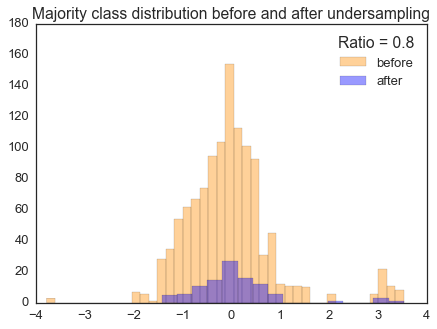

In [9]:
# plotting majority class distribution after undersampling
# displaying column 4

from IPython.html.widgets import interact
@interact(ratio=[0.1,1.0])

def plot_dist(ratio):
    sns.set(style="white", font_scale=1.3) 
    fig, ax = plt.subplots(figsize=(7,5))

    rus = RandomUnderSampler(ratio=ratio, random_state=7)
    X_res, y_res = rus.fit_sample(X_train_scaled, y_train)

    X_res_df = pd.DataFrame(X_res)

    ax = sns.distplot(X_train_scaled[4][y_train == -1], color='darkorange', \
                  kde=False, label='before')
    ax = sns.distplot(X_res_df[4][y_res == -1], color='b',  \
                  kde=False, label='after')         

    ax.set_ylim([0, 180])
    ax.set(xlabel='')
    ax.legend(title='Ratio = {}'.format(ratio))
    plt.title('Majority class distribution before and after undersampling')

    plt.show()

<h4> Cross-validation </h4>

The usual way to select parameters is via grid-search and cross-validation (CV). We will do a grid search over undersampling ratios, and the SVM rbf kernel tuning parameters. The five-fold CV is stratified so for each fold, the sampling ratios are preserved.   
The *imblearn package* includes a [pipeline](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline) module which allows one to chain transformers, resamplers and estimators. We use the pipeline to chain undersampling method with the SVM classifier.  
We will set-up a CV function to test out different undersampling methods. We will also vary the number of features.

The default CV scoring is based on the accuracy. When the classes are imbalanced, the true negative term (the accuracy of the majority class) dominates. Often, there is a high cost associated with the misclassification of the minority class, and in those cases alternative [scoring measures](http://scikit-learn.org/stable/modules/model_evaluation.html) such as the [F1](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) and [$F_{\beta}$](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) scores or the [Matthews Correlation Coefficient (MCC)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) (which uses all four values of the confusion matrix) are used. We will score the cross-validation using the MCC. We will also look at the True Positive Rate (accuracy of the minority class alone), the Accuracy and the confusion matrix when interpreting results.

<h5>CV setup</h5>

In [10]:
# defining the MCC metric to assess cross-validation

def tpr_score(y_true, y_pred):
    tprate = float(cm[1][1])/np.sum(cm[1])
    return tprate

def mcc_score(y_true, y_pred):
    mcc = matthews_corrcoef(y_true, y_pred)
    return mcc
    
mcc_scorer = make_scorer(mcc_score, greater_is_better=True)
tpr_scorer = make_scorer(tpr_score, greater_is_better=True)

In [11]:
# print classification results

def test_results(y_test, y_predicted):

    print '\nThe accuracy is: {0:4.2} ' \
    .format(accuracy_score(y_test, y_predicted))

    print '\nThe confusion matrix: '
    cm = confusion_matrix(y_test, y_predicted)
    print cm

    print '\nThe True Positive rate is: {0:4.2}' \
    .format(float(cm[1][1])/np.sum(cm[1]))

    print '\nThe Matthews correlation coefficient: {0:4.2f} \n' \
    .format(matthews_corrcoef(y_test, y_predicted))

    print(classification_report(y_test, y_predicted))

In [17]:
# grid search cross-validation function

def sampling_gridcv(samp_method, nfeatures):
      
    X_train_ = X_train_scaled.iloc[:,:nfeatures]
    X_test_ = X_test_scaled.iloc[:,:nfeatures]
    
    add_parameters = dict()
    if samp_method == 'rus':
        sampling = RandomUnderSampler(random_state=7)
        #[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        add_parameters = dict(samp__ratio = np.arange(1,11)*0.1)
    elif samp_method == 't1':
        sampling = TomekLinks(random_state=7)
    elif samp_method == 'ncr':
        sampling = NeighbourhoodCleaningRule(random_state=7)
 

    estimators = [('samp', sampling),
                  ('clf', SVC(probability=True, random_state=7))]
    
    parameters = dict(clf__C =[1, 10, 50, 100, 200],
                      clf__gamma=[.04, .05, .06, .07])
    parameters.update(add_parameters)

    pipe = ImbPipe(estimators)
    print pipe

    # stratified K-fold cross-validation
    cv = GridSearchCV(pipe, param_grid = parameters, cv =5, scoring=mcc_scorer)
    start = time()
    cv.fit(X_train_, y_train)
    print '\nGridSearchCV took {} seconds for {} candidate parameter settings.'\
    .format(time() - start, len(cv.grid_scores_))
    y_predicted = cv.predict(X_test_)
    #probas_ = cv.predict_proba(X_test_)
    print '\nThe best CV parameters are: {}' .format(cv.best_params_)
    
    # print test results using best parameters
    test_results(y_test, y_predicted)

<h5>CV Results</h5>

In [18]:
# random undersampling with 40 features

sampling_gridcv('rus', 40)

Pipeline(steps=[('samp', RandomUnderSampler(random_state=7, ratio='auto', replacement=True,
          return_indices=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=7, shrinking=True, tol=0.001,
  verbose=False))])

GridSearchCV took 48.9249770641 seconds for 200 candidate parameter settings.

The best CV parameters are: {'clf__gamma': 0.04, 'samp__ratio': 0.90000000000000002, 'clf__C': 1}

The accuracy is: 0.75 

The confusion matrix: 
[[227  66]
 [ 11  10]]

The True Positive rate is: 0.48

The Matthews correlation coefficient: 0.15 

             precision    recall  f1-score   support

         -1       0.95      0.77      0.85       293
          1       0.13      0.48      0.21        21

avg / total       0.90      0.75      0.81       314



In [19]:
sampling_gridcv('rus', 100)

Pipeline(steps=[('samp', RandomUnderSampler(random_state=7, ratio='auto', replacement=True,
          return_indices=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=7, shrinking=True, tol=0.001,
  verbose=False))])

GridSearchCV took 96.4308919907 seconds for 200 candidate parameter settings.

The best CV parameters are: {'clf__gamma': 0.04, 'samp__ratio': 0.80000000000000004, 'clf__C': 1}

The accuracy is: 0.81 

The confusion matrix: 
[[245  48]
 [ 13   8]]

The True Positive rate is: 0.38

The Matthews correlation coefficient: 0.14 

             precision    recall  f1-score   support

         -1       0.95      0.84      0.89       293
          1       0.14      0.38      0.21        21

avg / total       0.90      0.81      0.84       314



In [20]:
sampling_gridcv('rus', 140)

Pipeline(steps=[('samp', RandomUnderSampler(random_state=7, ratio='auto', replacement=True,
          return_indices=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=7, shrinking=True, tol=0.001,
  verbose=False))])

GridSearchCV took 126.518301964 seconds for 200 candidate parameter settings.

The best CV parameters are: {'clf__gamma': 0.04, 'samp__ratio': 0.90000000000000002, 'clf__C': 10}

The accuracy is: 0.87 

The confusion matrix: 
[[265  28]
 [ 14   7]]

The True Positive rate is: 0.33

The Matthews correlation coefficient: 0.19 

             precision    recall  f1-score   support

         -1       0.95      0.90      0.93       293
          1       0.20      0.33      0.25        21

avg / total       0.90      0.87      0.88       314



Based on initial experiments and the results of the CV above, undersampling with higher ratios like 0.8, 0.9, and 1.0 give higher MCC and True Positive values than lower ratios.

We will now run a simpler grid-search over C and gamma using the following parameters:
- ratio of 1.0 
- number of features = 40
- C = 1, 5, 7, 10
- gamma = 0.04, 0.05, 0.06

(When ratio is included as a grid-search parameter, the MCC and TPR scores are consistently lower. This requires some investigation since the size of the CV folds should not be affected by the complexity of the grid.)

In [22]:
# Second CV (using best CV parameters from previous run)

ratio = 1.0

X_train_ = X_train_scaled.iloc[:,:40]
X_test_ = X_test_scaled.iloc[:,:40]

rus = RandomUnderSampler(ratio=ratio, random_state=7)
X_res, y_res = rus.fit_sample(X_train_, y_train)

clf = SVC(random_state=7)

param_grid = {"C": [1, 5, 7, 10],
              "gamma": [0.04, 0.05, 0.06]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring=mcc_scorer)
start = time()
grid_search.fit(X_res, y_res)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
     % (time() - start, len(grid_search.grid_scores_)))
print '\nThe best CV parameters are: {}' .format(grid_search.best_params_)

# using model with best parameters on test set
y_predicted = grid_search.predict(X_test_)
test_results(y_test, y_predicted)

GridSearchCV took 0.38 seconds for 12 candidate parameter settings.

The best CV parameters are: {'C': 1, 'gamma': 0.06}

The accuracy is:  0.7 

The confusion matrix: 
[[206  87]
 [  6  15]]

The True Positive rate is: 0.71

The Matthews correlation coefficient: 0.22 

             precision    recall  f1-score   support

         -1       0.97      0.70      0.82       293
          1       0.15      0.71      0.24        21

avg / total       0.92      0.70      0.78       314



If an overall accuracy of 0.7 is acceptable, with random undersampling, we can get a TPR and MCC in the 0.71 and 0.22 range. These are the highest values obtained so far from experiments with sampling and cost-sensitive learning. 

<h3>IV. Data Cleaning + Undersampling </h3>

These methods emphasize data cleaning over data reduction.

<h4>1. Tomek Links</h4>

If a pair of minimally distanced nearest neighbors are of opposite classes, they are said to form a Tomek link <a href="#ref1">[1]</a> <a href="#ref3">[3]</a> . Tomek links (TL) are present both at class boundaries or when there is noise within a class. TL are used to cleanup the data set and establish well-defined class clusters and boundaries. We will perform a gridsearch CV using the *Imblearn* [Tomek Links](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.under_sampling.TomekLinks.html#imblearn.under_sampling.TomekLinks) method along with the SVM classifier in the section.

In [24]:
# Number of elements before/after TL

print 'Original dataset distribution: {}'.format(Counter(y_train))

tl = TomekLinks(random_state=7)
X_res, y_res = tl.fit_sample(X_train_scaled, y_train)

print 'Resampled dataset distribution: {}'.format(Counter(y_res))

Original dataset distribution: Counter({-1: 1170, 1: 83})
Resampled dataset distribution: Counter({-1: 1151, 1: 83})


In [25]:
sampling_gridcv('t1', 40)

Pipeline(steps=[('samp', TomekLinks(n_jobs=-1, random_state=7, return_indices=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=7, shrinking=True, tol=0.001,
  verbose=False))])

GridSearchCV took 37.1053049564 seconds for 20 candidate parameter settings.

The best CV parameters are: {'clf__gamma': 0.04, 'clf__C': 50}

The accuracy is: 0.93 

The confusion matrix: 
[[289   4]
 [ 18   3]]

The True Positive rate is: 0.14

The Matthews correlation coefficient: 0.22 

             precision    recall  f1-score   support

         -1       0.94      0.99      0.96       293
          1       0.43      0.14      0.21        21

avg / total       0.91      0.93      0.91       314



<h4>2. Neighborhood Cleaning Rule</h4>

The Neighborhood Cleaning Rule (NCL) is based on a 2001 paper by Laurikkala <a href="#ref4">[4]</a>. It is a combination of ENN (edited nearest neighbor where data points that differ from two of their three nearest neighbors are removed) and Tomek links. NCL emphasizes data cleaning over data reduction with the view that the quality of classification does not necessarily depend on the size of the class.  
We will perform a gridsearch CV using the *Imblearn* [Neighborhood Cleaning Rule](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.under_sampling.NeighbourhoodCleaningRule.html#imblearn.under_sampling.NeighbourhoodCleaningRule) method along with the SVM classifier.

In [26]:
# Number of elements before/after NCL

print 'Original dataset distribution: {}'.format(Counter(y_train))

ncr = NeighbourhoodCleaningRule(random_state=7)
X_res, y_res = ncr.fit_sample(X_train_scaled, y_train)

print 'Resampled dataset distribution: {}'.format(Counter(y_res))

Original dataset distribution: Counter({-1: 1170, 1: 83})
Resampled dataset distribution: Counter({-1: 1039, 1: 83})


In [28]:
sampling_gridcv('ncr', 40)

Pipeline(steps=[('samp', NeighbourhoodCleaningRule(n_jobs=-1, random_state=7, return_indices=False,
             size_ngh=3)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=7, shrinking=True, tol=0.001,
  verbose=False))])

GridSearchCV took 48.4742040634 seconds for 20 candidate parameter settings.

The best CV parameters are: {'clf__gamma': 0.04, 'clf__C': 10}

The accuracy is: 0.92 

The confusion matrix: 
[[284   9]
 [ 17   4]]

The True Positive rate is: 0.19

The Matthews correlation coefficient: 0.20 

             precision    recall  f1-score   support

         -1       0.94      0.97      0.96       293
          1       0.31      0.19      0.24        21

avg / total       0.90      0.92      0.91       314



<h3>V. Discussion</h3>

In our experiments, the simple Random Undersampling method gave much better results (with respect to the TPR of the minority class) than the TL and NCL methods which emphasize data cleaning. Furthermore, the undersampling also gave better results than [Oversampling with SMOTE](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_svm_smote.ipynb). The NCL method which incorporates TL gave marginally better results than using TL alone.

We expect a combination of oversampling, undersampling, data cleaning and boosting to give the best classification results for the minority class.
(writeup to be completed)


<h3>VI. References and Further Reading </h3>

<a name="ref1"></a>[1] [H. He and E. A. Garcia, “Learning from Imbalanced Data,” IEEE Trans. Knowledge and Data Engineering, vol. 21, issue 9, pp. 1263-1284, 2009. ](http://www.ele.uri.edu/faculty/he/PDFfiles/ImbalancedLearning.pdf)

<a name="ref2"></a>[2] [Lecture Notes based on “Learning from Imbalanced Data” by Haibo He](http://www.ele.uri.edu/faculty/he/PDFfiles/ImbalancedLearning_lecturenotes.pdf)

<a name="ref3"></a>[3] [I. Tomek, “Two modifications of CNN,” In Systems, Man, and Cybernetics, IEEE Transactions on, vol. 6, pp 769-772, 1976.](http://sci2s.ugr.es/keel/dataset/includes/catImbFiles/1976-Tomek-IEEETSMC.pdf)

<a name="ref4"></a>[4] [Laurikkala, Jorma. "Improving identification of difficult small classes by balancing class distribution." Conference on Artificial Intelligence in Medicine in Europe. Springer Berlin Heidelberg, 2001.](http://sci2s.ugr.es/keel/pdf/algorithm/congreso/2001-Laurikkala-LNCS.pdf)


<div style="background-color: #FAAC58; margin-left: 0px; margin-right: 20px; padding-bottom: 8px; padding-left: 8px; padding-right: 8px; padding-top: 8px;">


Author:  Meena Mani  <br>
email:   meenas.mailbag@gmail.com   <br> 
twitter: @meena_uvaca    <br>
</div>